# Numerical determination of $\sigma_0$

In [54]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import sys
import os,glob
import yaml
from chainconsumer import ChainConsumer
from scipy.special import gamma
from scipy.optimize import fsolve
from scipy.interpolate import interp1d  

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size']=13
plt.rcParams['font.family']='stix'
plt.rcParams['text.usetex']=True
plt.rcParams['figure.figsize']= (6.5,4)
plt.rcParams['figure.dpi']=150

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [205]:
masses_test = [1e-4,1e-3,1e-2,1e-1,1.,10.]
smallSigs = np.logspace(-20,-30,100)
largeSigs = np.logspace(-10,-30,30)

## IC generation

In [206]:
def make_inis(ini_base_file='class/inis/dmeff_base.ini',
              base_inis_path='class/inis/',
              class_runner_path = 'class/',
              npow=0,
              masses=masses_test,
              sigmas=smallSigs,
              output_path='pk_output',
              sh_file='class/run_classes.sh'):
    
    sh_file = class_runner_path+'run_classes.sh'

    fin =  open(ini_base_file, 'r')
    base_content = fin.read()
    fin.close()
    
    fout_sh = open(sh_file, 'w')

    for m in masses:
        if m<1:
            sigmas = smallSigs
        else:
            sigmas = largeSigs
            
        for sigma in smallSigs:
            filename = 'n{}_m{}_s{}.ini'.format(npow,m,sigma)
            #print('{}'.format(filename))
            fout_sh.write('./class ' + 'inis/{}\n'.format(filename))

            fout = open(base_inis_path + filename, 'w')
            fout.write(base_content)
            fout.write('\n')

            npow_line = 'npow_dmeff = {}\n'.format(npow)
            fout.write(npow_line)
            m_line = 'm_dmeff = {}\n'.format(m)
            fout.write(m_line)
            sigma_line = 'sigma_dmeff = {}\n'.format(sigma)
            fout.write(sigma_line)
            if npow<0:
                vel_line = 'Vrel_dmeff_rate = 30\n' #sets to DBK case.
                fout.write(vel_line)
            root_line = 'root = {}/n{}_m{}_s{}_\n'.format(output_path,npow,m,sigma)
            fout.write(root_line)
            
    fout_sh.close()

In [207]:
make_inis(npow=4)

## Relevant functions

In [208]:
def calculate_kcuts(npow=0, m=1e-3, z='z1',sigmas=smallSigs,
           pk_root='class/pk_output/', upper_cut=66, lower_cut=1, reduction_factor=0.75):
    
    data0 = np.loadtxt(pk_root + 'lcdm_{}_pk.dat'.format(z))
    ks = data0[:,0]
    pk0 = data0[:,1]
    khms = []
    ss = []
    
    if m<1:
        sigmas = smallSigs
    else:
        sigmas = largeSigs
        
    for i,sigma in enumerate(sigmas):
        filename = pk_root + 'n{}_m{}_s{}_{}_pk.dat'.format(npow,m,sigma,z)
        try:
            data = np.loadtxt(filename)
        except:
            continue
        pk = data[:,1]
   
        ind = (np.abs(np.abs((pk0-pk)/pk0) - reduction_factor)).argmin()
        if ks[ind]>upper_cut or ks[ind]<lower_cut:
            continue
#         print(ks[ind])
        khms.append(ks[ind])
        ss.append(sigmas[i])
    
    try:
        p = np.polyfit(np.log10(ss), np.log10(khms), 1)
    except:
        return -1
    
    return np.array(ss),np.array(khms),p

In [209]:
def fit_fun(x,p):
    pp = p[0]*np.log10(x) + p[1]
    return np.power(10,pp)

In [210]:
def sigma0_limit(kcut, masses=masses_test,
                npow=0, z=0,reduction_factor=0.25,
                ymax=1e-26,ymin=1e-31,plot_ks=True):
    
    masses = np.array(masses)
    sigmas = np.zeros(len(masses))

    for i,m in enumerate(masses):
        ks_filename = 'data/ks_{}_z{}_n{}_m{}.txt'.format(reduction_factor,z,npow,m)
#         try: 
        np.loadtxt(ks_filename)
#         except:
#             continue
        data = np.loadtxt(ks_filename)
        ss = data[:,0]
        ks = data[:,1]
        p = np.polyfit(np.log10(ks), np.log10(ss), 1)
        sigmas[i] = fit_fun(kcut,p)
                  
    return masses,sigmas

In [211]:
def show_pk(npow=0,m=0.01,sigmas=smallSigs,z='z1',
           pk_root='class/pk_output/',
            filename=None,lcdm_filename='lcdm_z1_pk.dat',label='',
           f=None,ax=None,xmin=0,xmax=20,ymin=-1.0,ymax=1e3,
           show_kcut=True,pfit=None, relative=True,boost_factor=1.):
        
    data0 = np.loadtxt(pk_root + lcdm_filename)
    ks = data0[:,0]
    pk0 = data0[:,1]
    
    if m<1:
        sigmas = smallSigs
    else:
        sigmas = largeSigs
            
    if filename is None:
        for i,sigma in enumerate(sigmas):
            filename = pk_root + 'n{}_m{}_s{}_{}_pk.dat'.format(npow,m,sigma,z)
#             try: 
            np.loadtxt(filename)
#             except:
#                 continue
            data = np.loadtxt(filename)
            pk = data[:,1]
            plt.semilogx(ks,(pk)/pk0,label=r'{}cm$^2$'.format(sigma))
#             plt.axvline(x=36,color='k')
            break
            
    plt.xlabel('k [1/Mpc]')
    plt.ylabel('P(k) residual')
    plt.xlim(1e-5,1e5)
#     plt.ylim(-1,)
    plt.show()

---

In [212]:
npow_=4

In [213]:
for m in masses_test:
    if calculate_kcuts(npow=npow_, m=m, z='z1') == -1:
        continue
    sigmas, kcuts, p = calculate_kcuts(npow=npow_, m=m, z='z1')

In [214]:
sigmas_ref = np.logspace(-10,-30,1000)
for m in masses_test:
    ks_filename = 'data/ks_0.25_z0_n{}_m{}.txt'.format(npow_,m)
    if calculate_kcuts(npow=npow_, m=m, z='z1') == -1:
        continue
    sigmas, kcuts, p = calculate_kcuts(npow=npow_, m=m, z='z1')
    ks = fit_fun(sigmas_ref,p)
    np.savetxt(ks_filename, np.vstack((sigmas_ref, ks)).T)

In [219]:
masses0,sigmas0=sigma0_limit(kcut=36,npow=0)
masses2,sigmas2=sigma0_limit(kcut=36,npow=2)
masses4,sigmas4=sigma0_limit(kcut=36,npow=4)
masses6,sigmas6=sigma0_limit(kcut=36,npow=6)

In [220]:
# masses6 = [masses6[0],masses6[1]]
# sigmas6 = [sigmas6[0],sigmas6[1]]

# masses4 = [masses4[0],masses4[1],masses4[2],masses4[3],masses4[2],masses4[1]]
# sigmas4 = [sigmas4[0],sigmas4[1],sigmas4[2],sigmas4[3],sigmas4[2],sigmas4[1]]

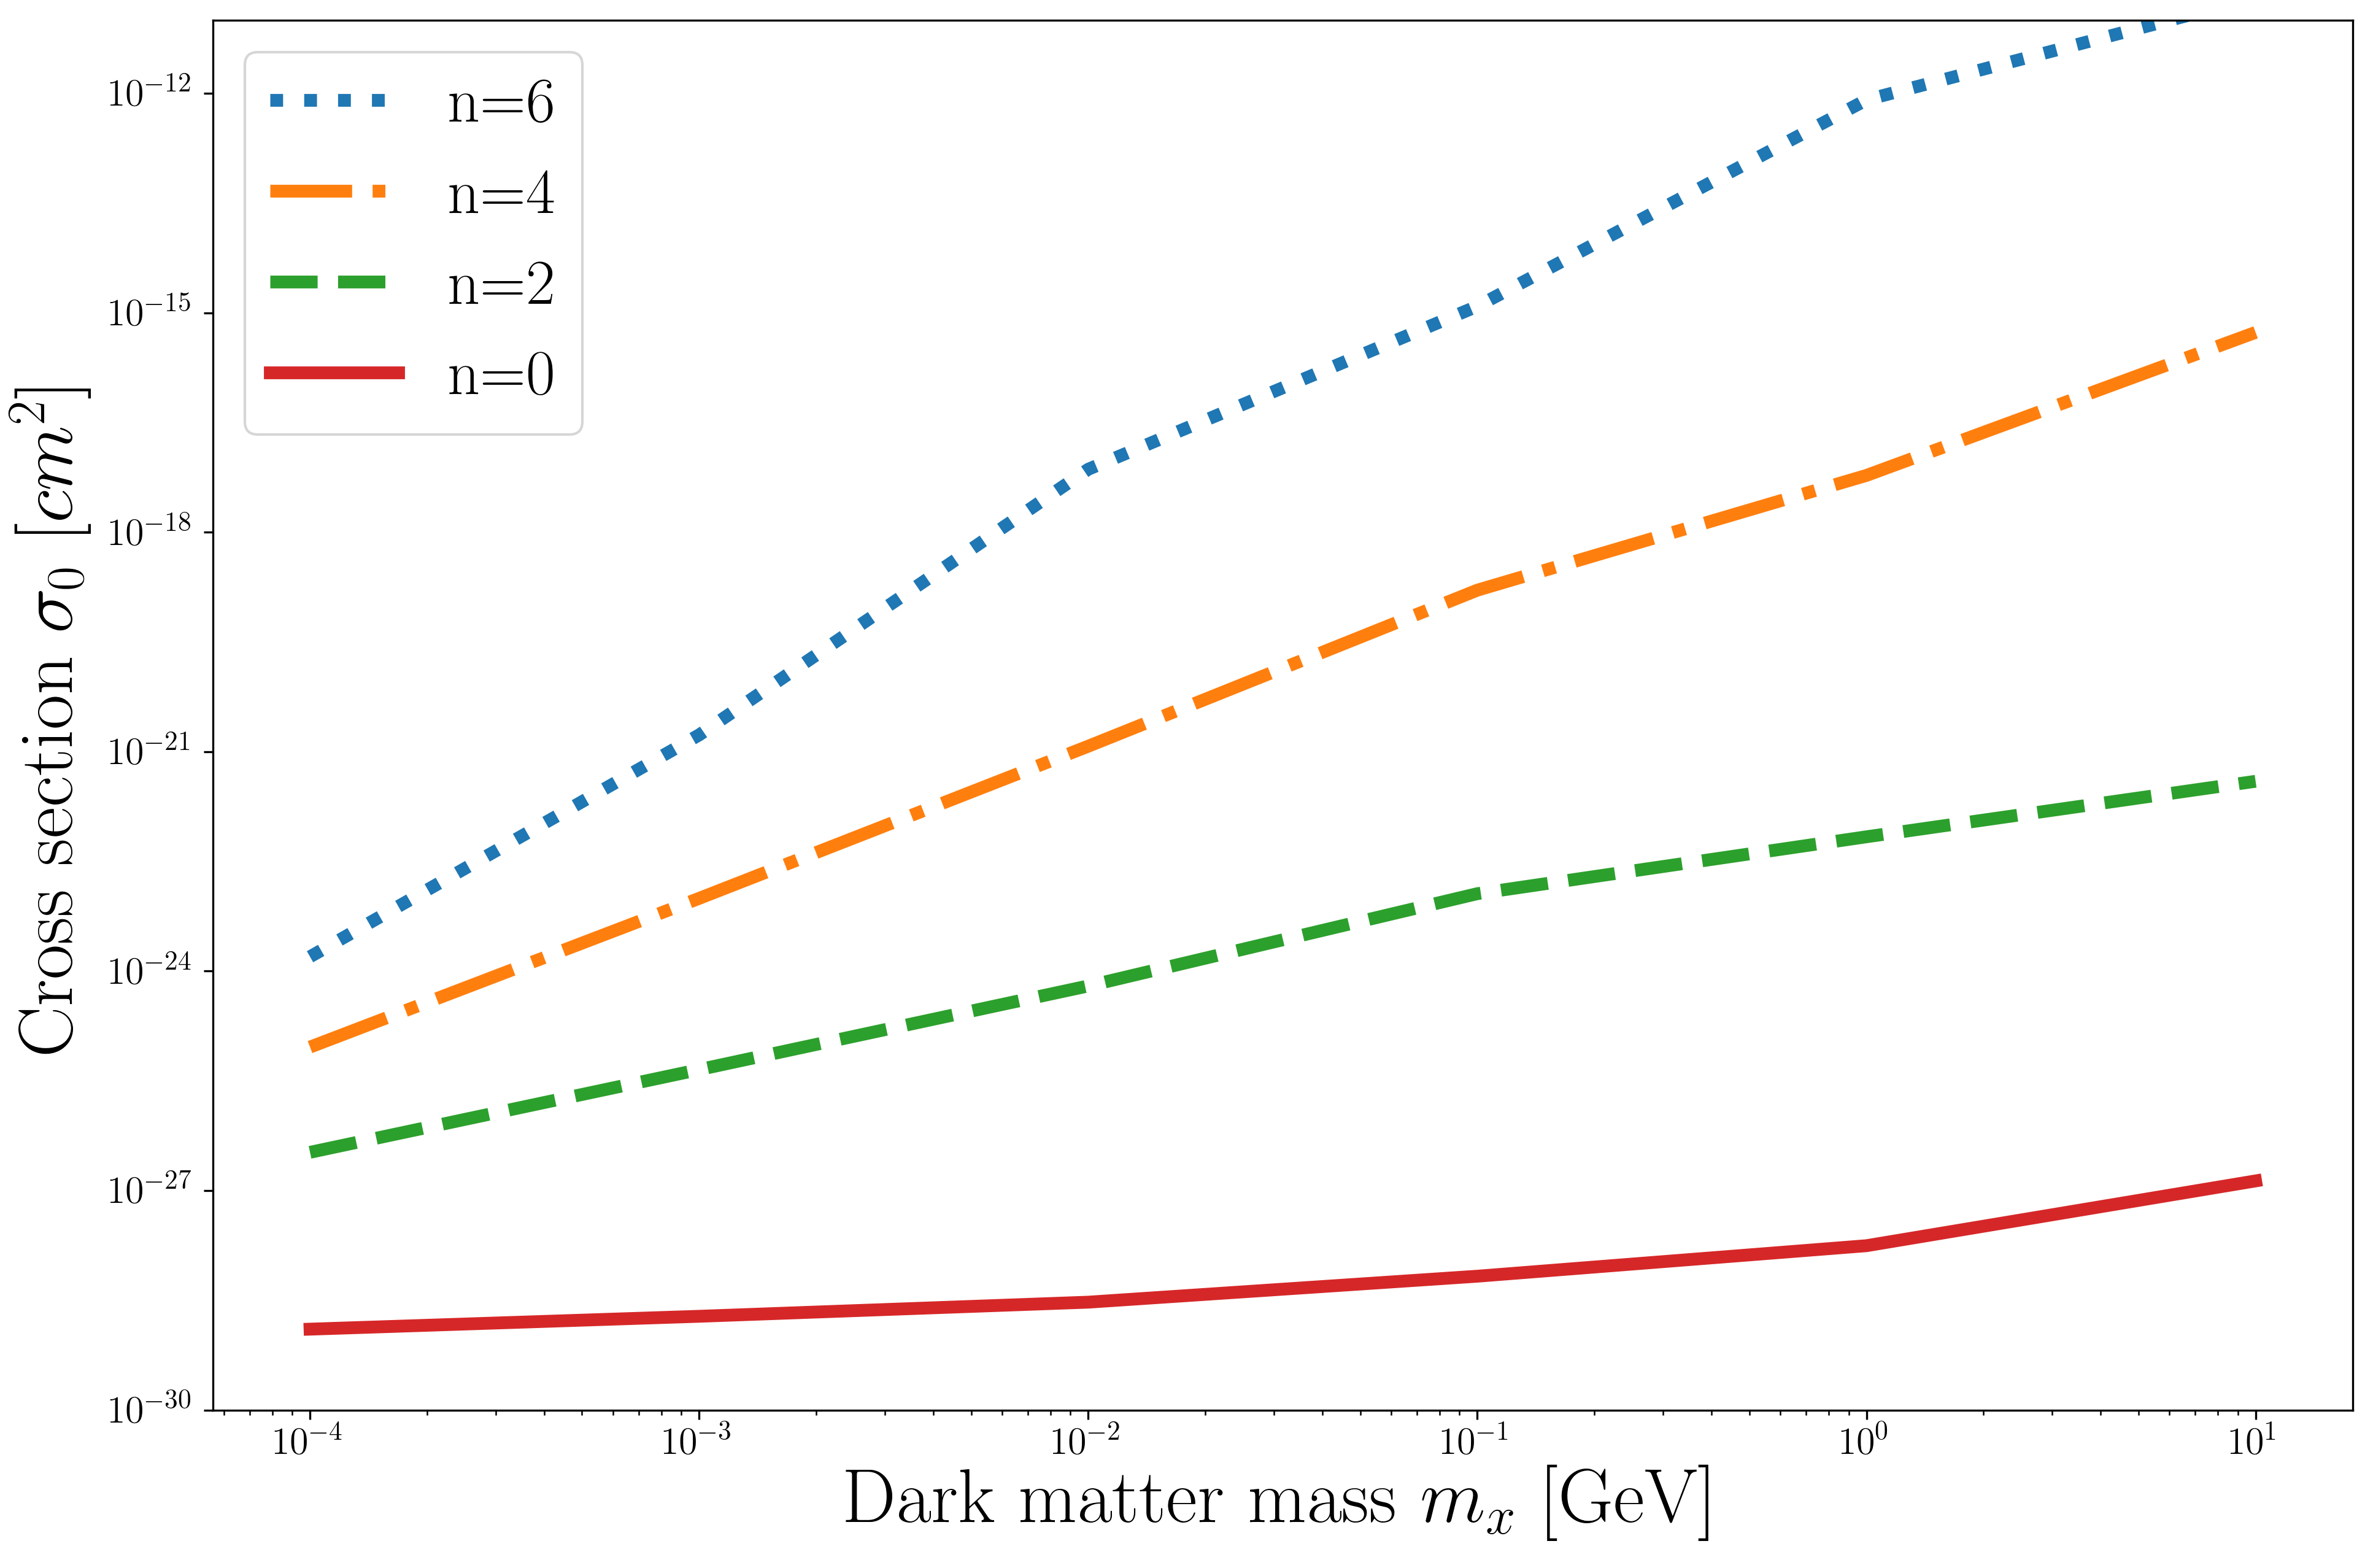

In [228]:
plt.figure(figsize=(15,10))

plt.loglog(masses6,sigmas6, label="n=6",linewidth=5,linestyle=':')
plt.loglog(masses4,sigmas4, label="n=4",linewidth=5,linestyle='-.')
plt.loglog(masses2,sigmas2, label="n=2",linewidth=5,linestyle='--')
plt.loglog(masses0,sigmas0, label="n=0",linewidth=5)

plt.ylabel(r"Cross section $\sigma_0$ [$cm^2$]", fontsize=30)
plt.xlabel(r"Dark matter mass $m_x$ [GeV]", fontsize=30)
plt.legend(fontsize=25)
plt.tick_params(labelsize=15)
plt.ylim(1e-30,1e-11)

plt.savefig("numerical.png")

In [117]:
show_pk(npow=6,masses=masses_test)

TypeError: show_pk() got an unexpected keyword argument 'masses'